## 1. Problem Statement

Write a neural network that can:

1. take 2 inputs:
    - an image from the MNIST dataset (say 5), and
    - a random number between 0 and 9, (say 7)
2. and gives two outputs:
    - the "number" that was represented by the MNIST image (predict 5), and
    - the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)
3. you can mix fully connected layers and convolution layers
4. you can use one-hot encoding to represent the random number input as well as the "summed" output.  
    a. Random number (7) can be represented as 0 0 0 0 0 0 0 1 0 0  
    b. Sum (13) can be represented as: 1. 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0  
    c. 0b1101 (remember that 4 digits in binary can at max represent 15, so we may need to go for 5 digits. i.e. 10010  

## 2. Importing required libraries & Checking GPU


In [28]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import warnings
warnings.filterwarnings('ignore')


print(torch.cuda.is_available())  # Checks if GPU is available
print(torch.cuda.get_device_name(0)) # Name of GPU
print(torch.cuda.device_count())

True
Tesla K80
1


## 3. Importing MNIST dataset from pytorch

In [29]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

mnist_train = datasets.MNIST('../data',train=True,download=True) # Train dataset
mnist_test = datasets.MNIST('./data',train=False,download=True) # Test dataset

## 3. Plotting few samples of the downloaded data

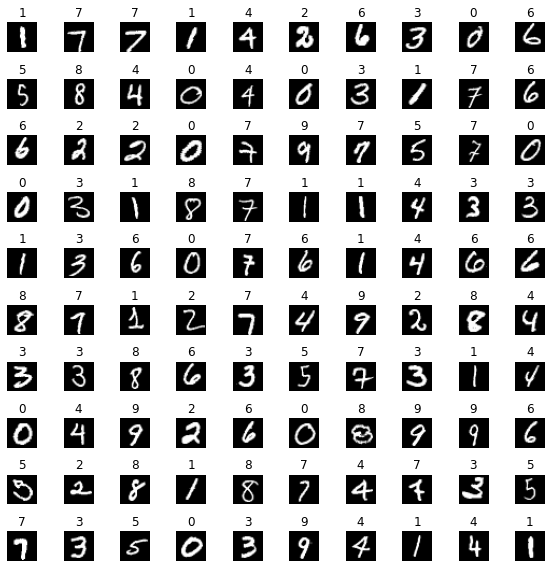

In [30]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    img, label = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
figure.tight_layout()
plt.show()

In [31]:
#dir(mnist_train)

## 4. Checking the size of the image, label and image information

In [32]:
print(f'Number of examples in training dataset :{len(mnist_train)}')
print(f'Shape of the training dataset - images : {mnist_train.data.shape}')
print(f'Labels in the training dataset : {mnist_train.targets}')

Number of examples in training dataset :60000
Shape of the training dataset - images : torch.Size([60000, 28, 28])
Labels in the training dataset : tensor([5, 0, 4,  ..., 5, 6, 8])


## 5. Defining Custom Dataset Class

In [33]:
from torch.utils.data import Dataset
from random import randrange

# Dataset is there to be able to interact with DataLoader

class MyDataset(Dataset):
  def __init__(self, inpDataset, transform):
    self.inpDataset = inpDataset
    self.transform = transform

  def __getitem__(self, index):
    randomNumber = randrange(10)
    sample_image, label = self.inpDataset[index]
    if self.transform:
        sample_image = self.transform(sample_image)

    sample = (sample_image,F.one_hot(torch.tensor(randomNumber),num_classes=10), label,label+randomNumber)
    return sample

  def __len__(self):
    return len(self.inpDataset)

myData_train = MyDataset(mnist_train,transform) 
myData_test = MyDataset(mnist_test,transform) 

In [34]:
image,randomNumber, label1, label2 = next(iter(myData_train))
image.shape,randomNumber, label1, label2

(torch.Size([1, 28, 28]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), 5, 14)

## 6. Creating DataLoader

In [35]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda") if use_cuda else torch.device("cpu")

train_kwargs = {'batch_size': 1000}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = torch.utils.data.DataLoader(myData_train,**train_kwargs)
test_loader = torch.utils.data.DataLoader(myData_test, **test_kwargs)

# train_loader = torch.utils.data.DataLoader(mnist_train,**train_kwargs)
# test_loader = torch.utils.data.DataLoader(mnist_test, **test_kwargs)

In [40]:
img,inp2,img_lbl,target_sum=next(iter(train_loader))

In [41]:
img.shape

torch.Size([1000, 1, 28, 28])

## 7. Defining Network

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9226, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(128, 20)

    def forward(self, x,y):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = torch.cat((x, y), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x1 = self.fc2(x)
        x2 = self.fc3(x)
        output1 = F.log_softmax(x1, dim=1)
        output2 = F.log_softmax(x2, dim=1)
        return output1, output2

In [43]:
model = Net().to(device)

In [44]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9226, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
)

In [45]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('/mnist_experiment_1')

## 8. Training Network

In [67]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for data,randomNumber,target,target1 in train_loader:
        data,randomNumber,target,target1 = data.to(device), randomNumber.to(device), target.to(device), target1.to(device)
        optimizer.zero_grad()
        output, output1 = model(data,randomNumber)
        loss = F.nll_loss(output, target) + F.nll_loss(output1, target1) * 2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss/data.shape[0]


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    correct1 = 0
    with torch.no_grad():
        for data,randomNumber,target,target1 in tqdm(test_loader):
            data,randomNumber,target,target1 = data.to(device), randomNumber.to(device), target.to(device), target1.to(device)
            output, output1 = model(data,randomNumber)
            test_loss += F.nll_loss(output, target, reduction='sum').item() + F.nll_loss(output1, target1, reduction='sum').item() * 2  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred1 = output1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()

    test_loss /= len(test_loader.dataset)


In [68]:
optimizer = optim.SGD(model.parameters(), lr=0.1,  momentum=0.9)
epochs = 20
loss_T=[]
# scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in tqdm(range(1, epochs + 1)):
    loss= train(model, device, train_loader, optimizer, epoch)
    loss_T.append(loss)
    writer.add_scalar('training loss',
                            loss,
                            epoch)
    test(model, device, test_loader)


    # scheduler.step()
writer.close()

  0%|          | 0/20 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe422332dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe422332dd0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    i

In [69]:
loss_T

[0.01784162710607052,
 0.017399561628699302,
 0.01777971987426281,
 0.01680593091249466,
 0.017134321346879006,
 0.016833370521664618,
 0.01585548961162567,
 0.015409240677952766,
 0.015761807709932327,
 0.015437174573540687,
 0.015020667508244514,
 0.014861510932445527,
 0.014923973888158798,
 0.014718947917222976,
 0.01450993137061596,
 0.014321574151515961,
 0.01419252496957779,
 0.014125840991735458,
 0.013358502835035323,
 0.013265004441142082]

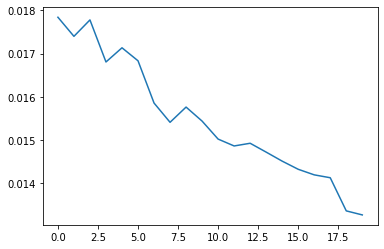

In [75]:
plt.plot(range(20),loss_T)